# MNIST

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Выгрузка и предобработка данных

In [3]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(42000, 785)

Проверим пустые значения

In [5]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [6]:
df.isna().sum().sum()

0

Отделим от датасета целевую переменную

In [7]:
y = df['label']

In [8]:
X = df.drop('label', axis='columns')

In [9]:
y.shape, X.shape

((42000,), (42000, 784))

Посмотрим на распределение классов

<Axes: >

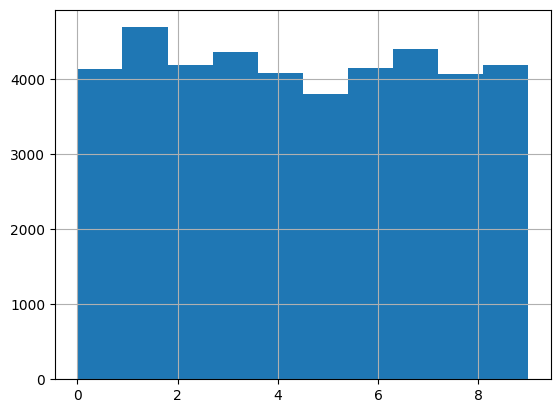

In [10]:
y.hist()

Как видим все классы, почти распределены равномерно

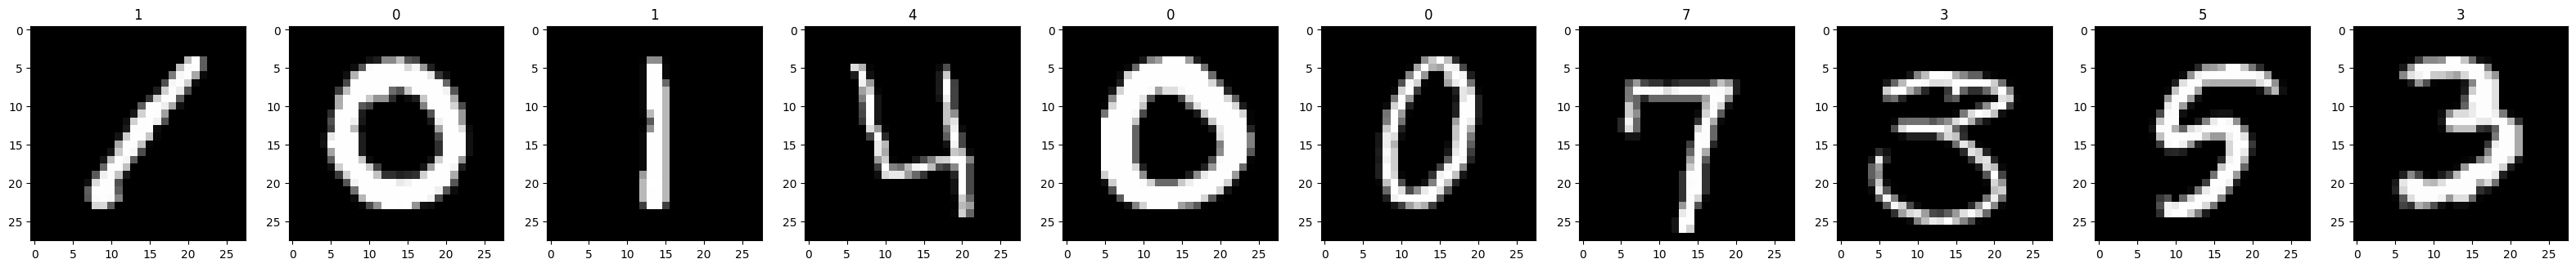

In [11]:
fig, ax = plt.subplots(1, 10, figsize=(40,10))
for i in range(10):
    im = X.iloc[i].to_numpy().reshape(28,28)
    ax[i].imshow(im, cmap='gray')
    ax[i].set_title(str(y[i]))

## Построение моделей

### Разбиение на тренировочную и валидационную выборки

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)
print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)

X_train.shape: (29400, 784)
X_val.shape: (12600, 784)
y_train.shape: (29400,)
y_val.shape: (12600,)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [17]:
X_train_t = torch.FloatTensor(X_train.to_numpy())
y_train_t = torch.LongTensor(y_train.to_numpy())
X_val_t = torch.FloatTensor(X_val.to_numpy())
y_val_t = torch.LongTensor(y_val.to_numpy())

train_dataloader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=10)
val_dataloader = DataLoader(TensorDataset(X_val_t, y_val_t))

### Функция обучения

In [25]:
from tqdm import tqdm
def train(model, loss_fn, opt, train_loses, dataloader, epoch):
    for _ in tqdm(range(epoch)):
        for i, (X_batch, y_batch) in enumerate(dataloader):
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            if i % 1000 == 0:
                train_loses.append(loss.item())
    return train_loses

In [20]:
from sklearn.metrics import accuracy_score
def get_metrics(model, X_train_t, y_train_t, X_val_t, y_val_t):
    with torch.no_grad():
        y_train_pred = model(X_train_t)
        pred_train_label = abs(y_train_pred.numpy()).argmax(axis=1)
        a_train_fln = accuracy_score(y_train_t.numpy(), pred_train_label)
        y_val_pred = model(X_val_t)
        pred_val_label = abs(y_val_pred.numpy()).argmax(axis=1)
        a_val_fln = accuracy_score(y_val_t.numpy(), pred_val_label)
    return a_train_fln, a_val_fln

### Сверточная сеть

In [21]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1)    #28x28
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))                                             #14x14
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))               #12x12
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))                                             #6x6
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3))               #4x4
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))                                             #2x2
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=256, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [22]:
lr = 1e-3
model_cnn = MyCNN()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_cnn.parameters(), lr=lr)
train_loses_cnn = []

In [30]:
X_train_t_cnn = X_train_t.reshape([X_train_t.shape[0], 28,28])
X_train_t_cnn = X_train_t_cnn[:,None,:,:]
train_dataloader_cnn = DataLoader(TensorDataset(X_train_t_cnn, y_train_t), batch_size=1)

In [ ]:
train_loses_cnn = train(model_cnn, loss_fn, opt, train_loses_cnn, train_dataloader_cnn, 50)

<Axes: >

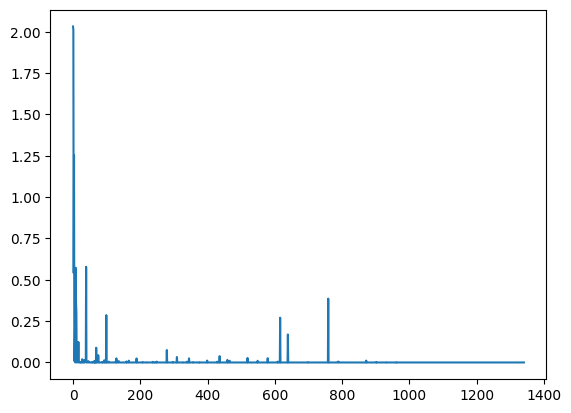

In [34]:
sns.lineplot(train_loses_cnn)

In [35]:
X_train_t_cnn = X_train_t.reshape([X_train_t.shape[0], 28,28])
X_train_t_cnn = X_train_t_cnn[:,None,:,:]
X_val_t_cnn = X_val_t.reshape([X_val_t.shape[0], 28,28])
X_val_t_cnn = X_val_t_cnn[:,None,:,:]
a_train_cnn, a_val_cnn = get_metrics(model_cnn, X_train_t_cnn, y_train_t, X_val_t_cnn, y_val_t)
print("Accuracy train:", a_train_cnn)
print("Accuracy val:", a_val_cnn)

Accuracy train: 0.9997959183673469
Accuracy val: 0.9913492063492063


In [135]:
torch.save(model_cnn, 'model_cnn.pt')